In [1]:
using Colors
using CSV
using DataFrames
using Graphs
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, countmap
using Statistics

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

include("../src/Network.jl")
using .Network: create_weighted_cycle_graph, create_cycle_graph, desc, plot_degree_distribution, mat_nv, mat_ne, mat_degree, mat_update_weight!, plot_graph, average_distance

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, Strategy, C, D

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
);

In [3]:
FILE_NAMES = [
    "../output/CircleModel_20240826_144719.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_182404.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_200917.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_113854.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_191857.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240827_170414.csv",  # combination, 10 trials
    "../output/CircleModel_20240827_181750.csv",  # combination, 10 trials
    # "../output/CircleModel_20240827_100534.csv",  # all, 10 trials
    "../output/CircleModel_20240827_215238.csv",  # all, 10 trials
    "../output/CircleModel_20240828_213318.csv",  # all, 10 trials
    "../output/CircleModel_20240829_093929.csv",  # all, 10 trials
    "../output/CircleModel_20240829_154557.csv",  # all, 10 trials
    "../output/CircleModel_20240829_210419.csv",  # all, 10 trials
];

In [4]:
dfs = [DataFrame(CSV.File(n)) for n in FILE_NAMES]
df = vcat(dfs...);

In [5]:
regional_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    df.resource_limit_β .== 0.0 .&&
    df.resource_limit_σ .== 0.0, :]

universal_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    df.peak_node_variability .== 0 .&&
    df.resource_limit_σ .!= 0.0, :]

b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
peak_node_variability_vec = [1, 2, 4, 8, 16]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]

combination_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    ([x in b_vec for x in df.b]) .&&
    ([x in peak_node_variability_vec for x in df.peak_node_variability]) .&&
    ([x in resource_limit_β_vec for x in df.resource_limit_β]) .&&
    ([x in resource_limit_σ_vec for x in df.resource_limit_σ]), :]

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df)

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

regional_var_df = groupby_combine_sort(regional_var_df, [:b, :peak_node_variability])
universal_var_df = groupby_combine_sort(universal_var_df, [:b, :resource_limit_β, :resource_limit_σ])
combination_var_df = groupby_combine_sort(combination_var_df, [:b, :peak_node_variability, :resource_limit_β, :resource_limit_σ])

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df);

size(regional_var_df) = (3850, 17)
size(universal_var_df) = (3520, 17)
size(combination_var_df) = (1750, 17)
size(regional_var_df) = (550, 3)
size(universal_var_df) = (440, 4)
size(combination_var_df) = (250, 5)


In [6]:
regional_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.resource_limit_β .== 0.0 .&&
    df.resource_limit_σ .== 0.0, :]

universal_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.peak_node_variability .== 0 .&&
    df.resource_limit_σ .!= 0.0, :]

b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
peak_node_variability_vec = [1, 2, 4, 8, 16]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]

combination_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    ([x in b_vec for x in df.b]) .&&
    ([x in peak_node_variability_vec for x in df.peak_node_variability]) .&&
    ([x in resource_limit_β_vec for x in df.resource_limit_β]) .&&
    ([x in resource_limit_σ_vec for x in df.resource_limit_σ]), :]

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df)

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

regional_var_df = groupby_combine_sort(regional_var_df, [:relationship_increment_factor, :b, :peak_node_variability])
universal_var_df = groupby_combine_sort(universal_var_df, [:relationship_increment_factor, :b, :resource_limit_β, :resource_limit_σ])
combination_var_df = groupby_combine_sort(combination_var_df, [:relationship_increment_factor, :b, :peak_node_variability, :resource_limit_β, :resource_limit_σ])

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df);

size(regional_var_df) = (11550, 17)
size(universal_var_df) = (10560, 17)
size(combination_var_df) = (5250, 17)
size(regional_var_df) = (1650, 4)
size(universal_var_df) = (1320, 5)
size(combination_var_df) = (750, 6)


In [7]:
default(tickfont=font(10))

function plot_fig_regional(df::DataFrame)::Plots.Plot
    df.peak_node_variability = Float64.(df.peak_node_variability)
    replace!(df.peak_node_variability, 0 => 0.5)
    fRI = df.relationship_increment_factor[1]

    xticks = sort(unique(df.peak_node_variability))
    xticks_label = [x in [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 49.0] ? "$(Int(x))" : "" for x in xticks]
    xticks_label[1] = "0"

    p = plot(
        xticks=(xticks, xticks_label),
        xscale=:log2,
        xlim=(0.5, 49),
        yticks=0:0.1:1,
        ylim=(0, 1),
        xlabel="\\sigma_R",
        ylabel="Cooperation Rate",
        title="Impact of Regional Variability on Cooperation",
        tickfont = "Arial",
        legend=(0.11, 0.94),
    )

    for _df in groupby(df, [:b])
        plot!(_df.peak_node_variability, _df.cooperation_rate, label="b=$(_df.b[1])", linewidth=1.5)
    end

    savefig("img/fig2a.png")

    return p
end;

function plot_fig_universal(df::DataFrame)::Vector{Plots.Plot}
    σ_vec = sort(unique(df.resource_limit_σ))
    β_vec = sort(unique(df.resource_limit_β))
    p_vec = []
    fRI = df.relationship_increment_factor[1]

    for σ in σ_vec
        p = plot(
            xticks=β_vec,
            xlim=(minimum(β_vec), maximum(β_vec)),
            yticks=0:0.1:0.5,
            ylim=(0, 0.35),
            xlabel="\\beta",
            ylabel="Cooperation Rate",
            title="Impact of Universal Variability (\\sigma_{\\theta} = $(σ))",
            tickfont = "serif-roman",
        )

        sort!(df, :b, rev=true)
        for (i, _df) in enumerate(groupby(df[df.resource_limit_σ .== σ, :], [:b]))
            plot!(_df.resource_limit_β, _df.cooperation_rate, label=false, lw=1.5, lc=CS.COLORS[i])
        end

        push!(p_vec, p)
        savefig("img/fig2_universal_$(fRI)_$(σ).png")
    end

    return p_vec
end;

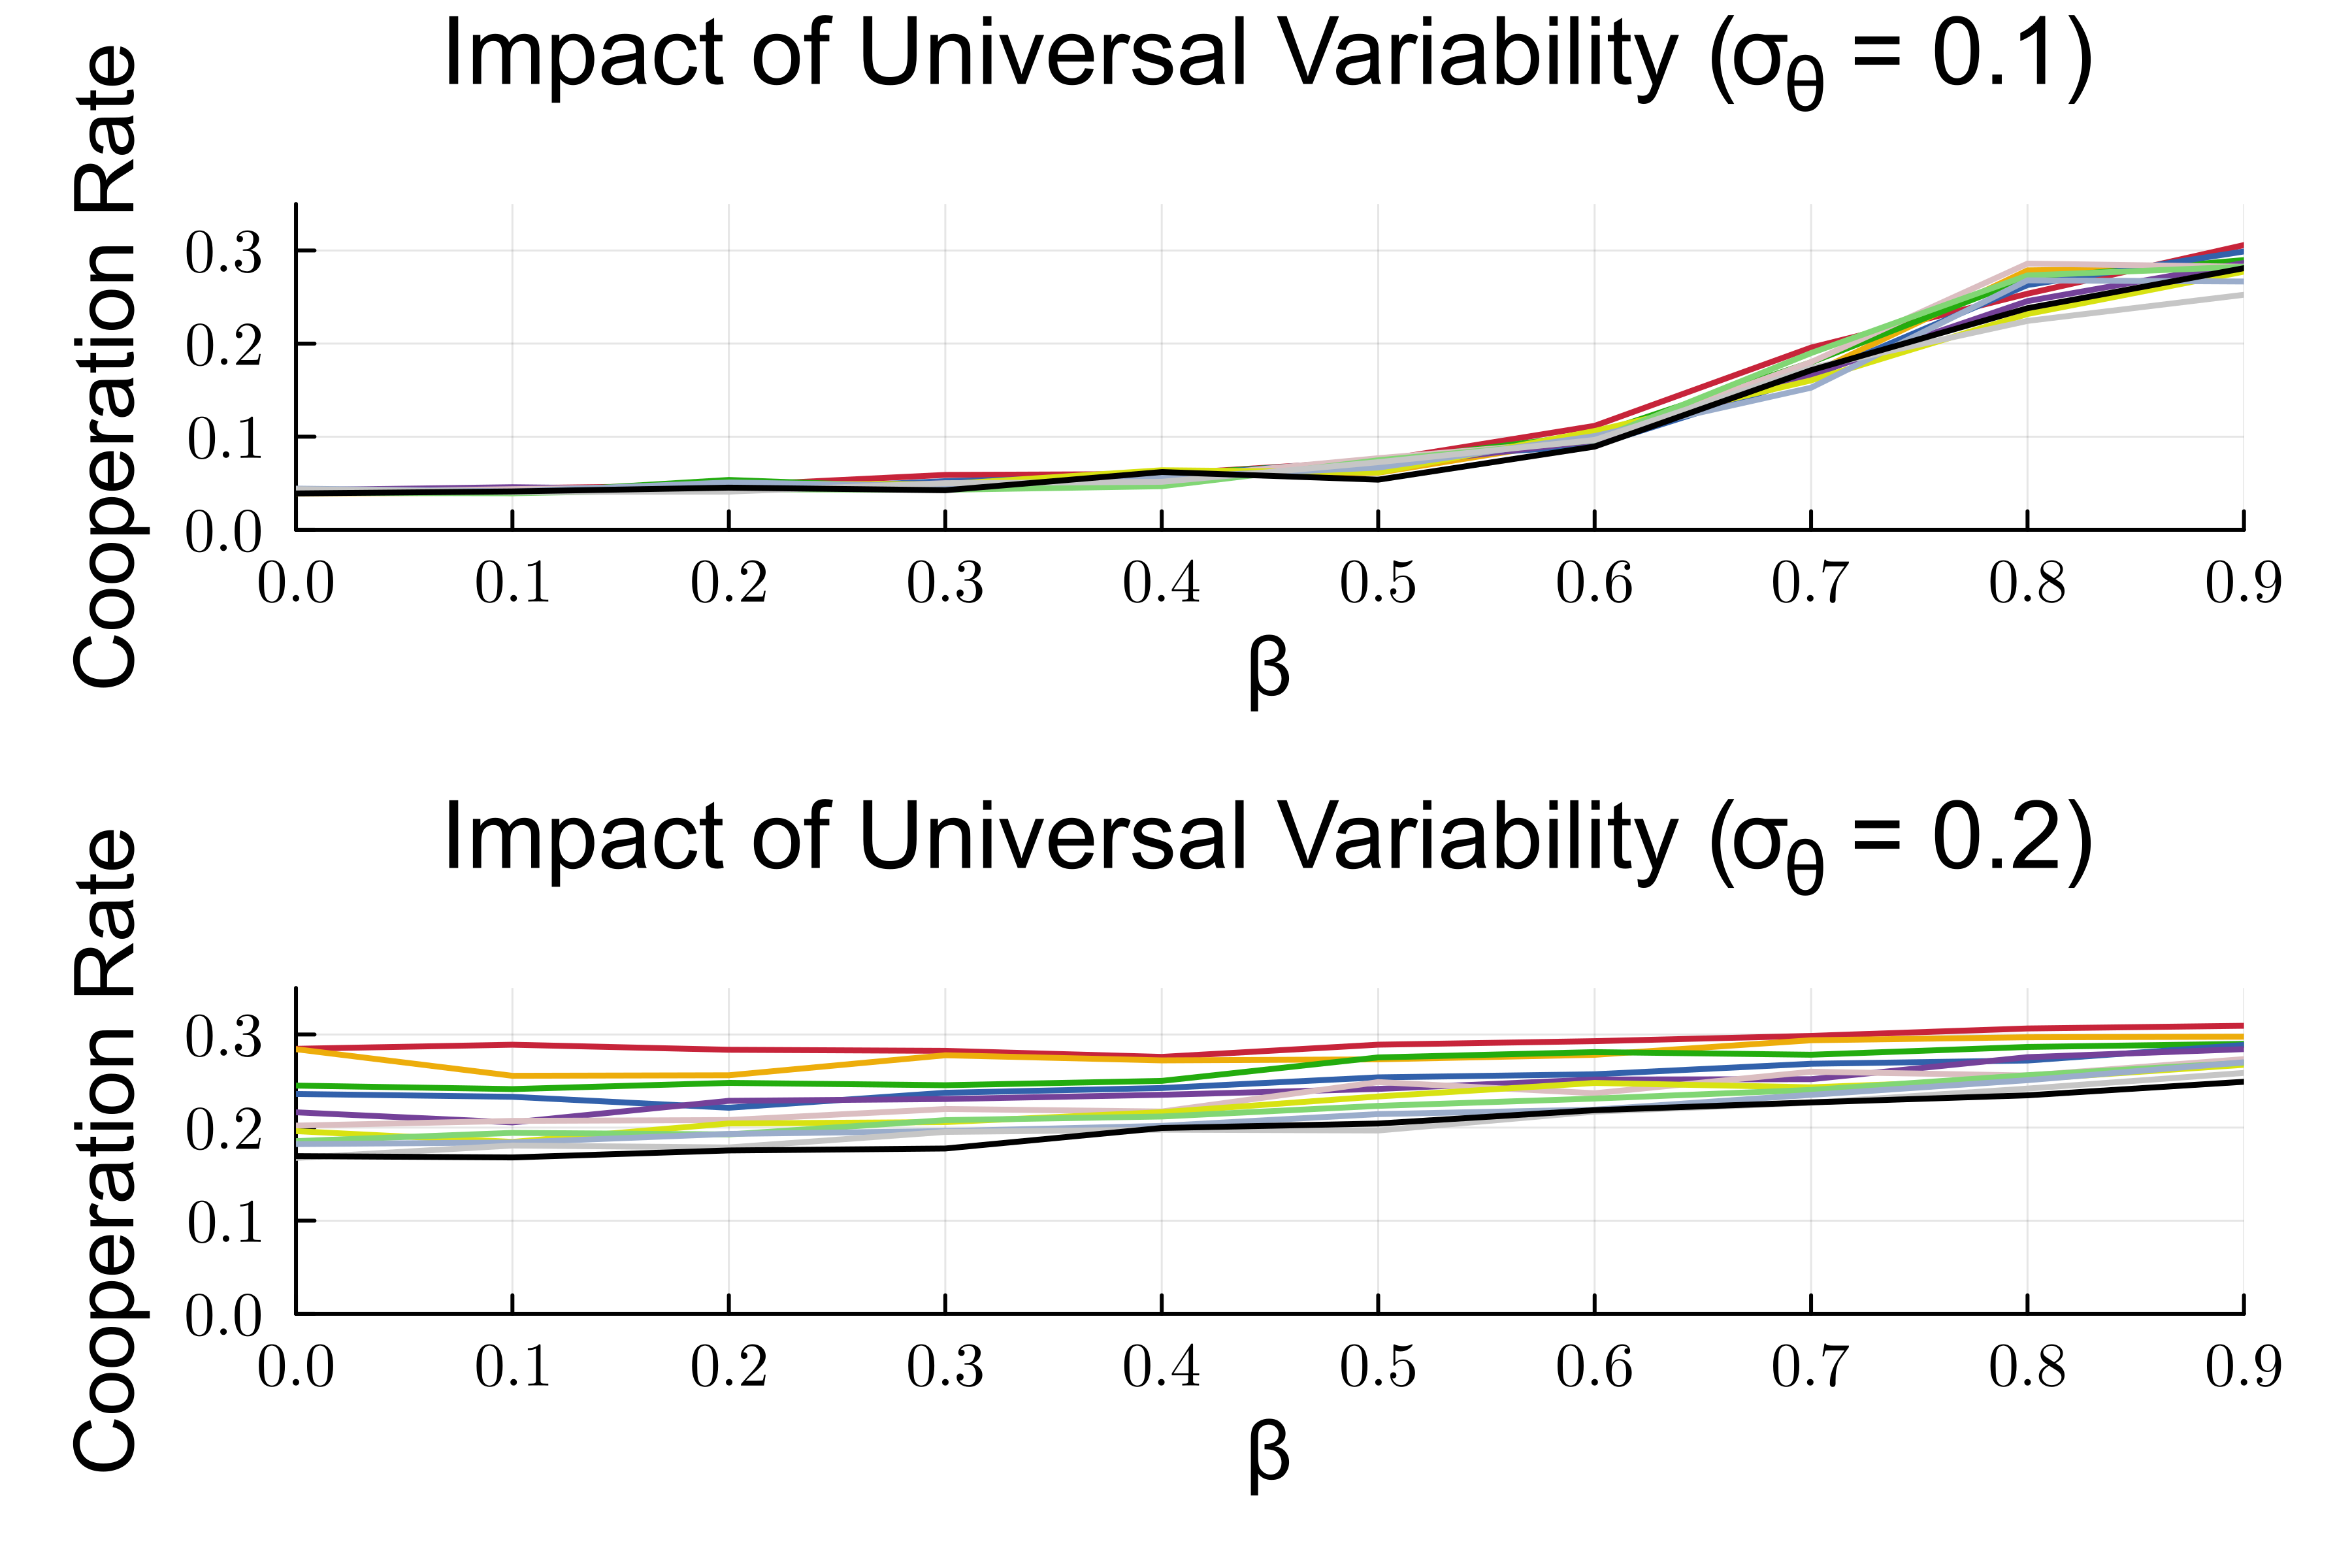

In [8]:
plot(
    plot_fig_universal(universal_var_df[universal_var_df.relationship_increment_factor .== 1.0, :])[2],
    plot_fig_universal(universal_var_df[universal_var_df.relationship_increment_factor .== 1.0, :])[3],
    layout=(2, 1)
) |> display
savefig("img/Fig3a.png");